Import des librairies

In [1]:
import os

import logging
import numpy
import pandas as pd
import matplotlib.pyplot as plt

from autots import AutoTS

Liste des chemins vers les fichiers

In [2]:
list_of_path_files = [
                 'data/data-meteo-2014.csv',
                 'data/data-meteo-2015.csv',
                 'data/data-meteo-2016.csv',
                 'data/data-meteo-2017.csv',
                 'data/data-meteo-2018.csv',
                 'data/data-meteo-2019.csv',
                 'data/data-meteo-2020.csv',
                 'data/data-meteo-2021.csv',
                 'data/data-meteo-2022.csv',
                 'data/data-meteo-2023.csv']

traitement des fichiers CSV

In [3]:
from tensorboard.notebook import display

dataframes = []

for path in list_of_path_files:
    df = pd.read_csv(path, delimiter=';')
    dataframes.append(df)

dataframe_assembled = pd.concat(dataframes, axis=0)

columns = ['ID OMM station', 'Date', 'Température (°C)', 'Humidité', 'Vitesse du vent moyen 10 mn', 'Pression station', 'Précipitations dans les 24 dernières heures']


dataframe_result = dataframe_assembled[columns]

dataframe_result = dataframe_result.rename(columns={'ID OMM station': 'ID', 'Température (°C)': 'Temperature (°C)','Vitesse du vent moyen 10 mn' :'Vitesse du vent moyen (km/h)', 'Précipitations dans les 24 dernières heures': 'Precipitations'})

#Date + label + ete hiver printemps automne

dataframe_result['Vitesse du vent moyen (km/h)'] = dataframe_result['Vitesse du vent moyen (km/h)']/10 * 6

dataframe_result.to_csv('./data/dataset.csv', index=False, sep=';')

Information sur le Dataset

In [4]:
df = pd.read_csv('data/dataset.csv', delimiter=';')

# Compter le nombre de valeurs manquantes par colonne
missing_values_count = df.isnull().sum()

print(missing_values_count)

print('*************************************')

# Compter le nombre de lignes du DataFrame
nombre_lignes = df.shape[0]

print("Nombre de lignes du DataFrame :", nombre_lignes)

ID                                 0
Date                               0
Temperature (°C)                   1
Humidité                           1
Vitesse du vent moyen (km/h)       1
Pression station                   1
Precipitations                  2733
dtype: int64
*************************************
Nombre de lignes du DataFrame : 23340


Graphe sur les valeurs manquantes

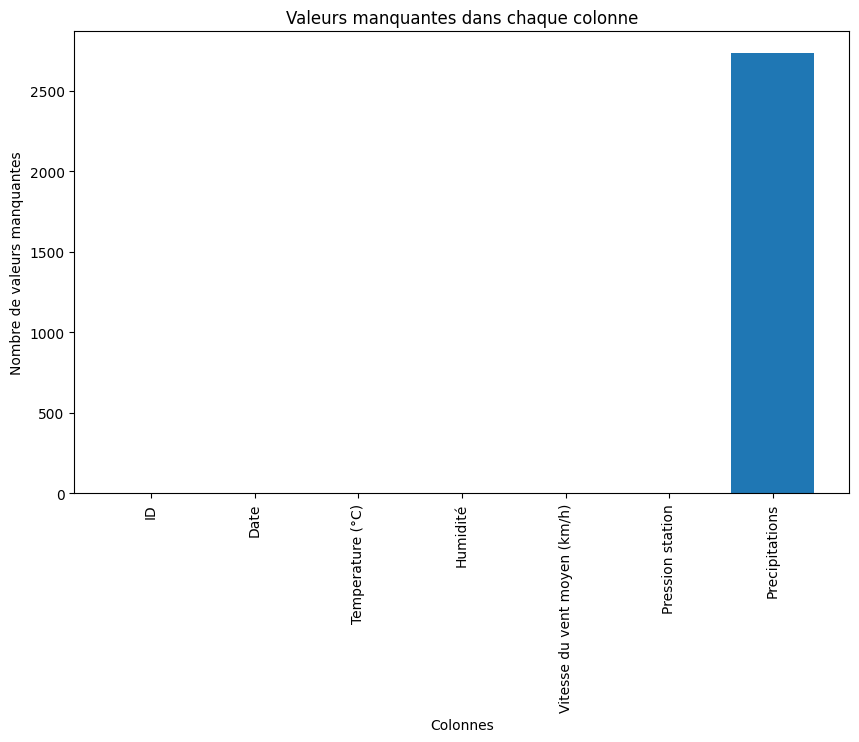

In [5]:
missing_values = df.isnull().sum()
plt.figure(figsize=(10, 6))
plt.bar(missing_values.index, missing_values.values)
plt.xlabel('Colonnes')
plt.ylabel('Nombre de valeurs manquantes')
plt.title('Valeurs manquantes dans chaque colonne')
plt.xticks(rotation=90)
plt.show()

Nettoyage du Dataset de la colonne Précipitations

In [6]:
#Imputation par la moyenne
df['Precipitations'].fillna(df['Precipitations'].mean(), inplace=True)


Implémentation du modèle

In [7]:
df['Date'] = pd.to_datetime(df['Date'], utc=True)
print(df['Date'])

0       2014-11-21 18:00:00+00:00
1       2014-11-13 00:00:00+00:00
2       2014-12-19 21:00:00+00:00
3       2014-12-24 15:00:00+00:00
4       2014-12-28 03:00:00+00:00
                   ...           
23335   2021-08-28 12:00:00+00:00
23336   2021-09-02 00:00:00+00:00
23337   2021-09-03 18:00:00+00:00
23338   2021-08-01 18:00:00+00:00
23339   2021-08-06 12:00:00+00:00
Name: Date, Length: 23340, dtype: datetime64[ns, UTC]


Données d'entraînement et de test

In [8]:
train = df[df['Date'] <= '2022-12-31']
test = df[df['Date'] > '2022-12-31']

Implémentation du modèle

In [ ]:
model = AutoTS(forecast_length=3,
               frequency='D',
               prediction_interval=0.9,
               ensemble=None,
               model_list = 'fast',
               transformer_list="fast",
               max_generations=4,
               num_validations=2,
               validation_method="backwards",
               n_jobs='auto'
               )

model = model.fit(train, date_col='Date', value_col='Temperature (°C)', id_col=None)

prediction = model.predict()

prediction.plot(model.df_wide_numeric,
                series=model.df_wide_numeric.columns[0],
                start_date="2023-01-01")

print(model)

forecast = prediction.forecast()

forecasts_up, forecasts_low = prediction.upper_forecast, prediction.lower_forecast

model_results = model.results()

validation_results = model.results("validation")

Using 3 cpus for n_jobs.
Model Number: 1 with model AverageValueNaive in generation 0 of 4
Model Number: 2 with model AverageValueNaive in generation 0 of 4
Model Number: 3 with model AverageValueNaive in generation 0 of 4
Model Number: 4 with model DatepartRegression in generation 0 of 4
Model Number: 5 with model DatepartRegression in generation 0 of 4
Model Number: 6 with model DatepartRegression in generation 0 of 4


/Users/chnmichel/opt/miniconda3/envs/DL_COURS/lib/python3.10/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/Users/chnmichel/opt/miniconda3/envs/DL_COURS/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
2023-07-23 13:41:24.455579: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Model Number: 7 with model DatepartRegression in generation 0 of 4


2023-07-23 13:41:32.599828: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Epoch 1/50
92/92 [==============================] - 8s 4ms/step - loss: 0.3729
Epoch 2/50
92/92 [==============================] - 0s 3ms/step - loss: 0.2708
Epoch 3/50
92/92 [==============================] - 0s 3ms/step - loss: 0.2370
Epoch 4/50
92/92 [==============================] - 0s 4ms/step - loss: 0.2198
Epoch 5/50
92/92 [==============================] - 0s 4ms/step - loss: 0.2063
Epoch 6/50
92/92 [==============================] - 0s 3ms/step - loss: 0.1995
Epoch 7/50
92/92 [==============================] - 0s 3ms/step - loss: 0.2018
Epoch 8/50
92/92 [==============================] - 0s 4ms/step - loss: 0.1955
Epoch 9/50
92/92 [==============================] - 0s 4ms/step - loss: 0.1921
Epoch 10/50
92/92 [==============================] - 0s 3ms/step - loss: 0.1922
Epoch 11/50
92/92 [==============================] - 0s 3ms/step - loss: 0.1904
Epoch 12/50
92/92 [==============================] - 0s 3ms/step - loss: 0.1889
Epoch 13/50
92/92 [==============================

/Users/chnmichel/opt/miniconda3/envs/DL_COURS/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


Model Number: 29 with model DatepartRegression in generation 0 of 4
Model Number: 30 with model ETS in generation 0 of 4
Model Number: 31 with model VECM in generation 0 of 4
Template Eval Error: ValueError('Only gave one variable to VECM') in model 31 in generation 0: VECM
Model Number: 32 with model MultivariateMotif in generation 0 of 4
Model Number: 33 with model MultivariateMotif in generation 0 of 4
Model Number: 34 with model UnivariateMotif in generation 0 of 4
Model Number: 35 with model UnivariateMotif in generation 0 of 4
Model Number: 36 with model SectionalMotif in generation 0 of 4
Model Number: 37 with model SectionalMotif in generation 0 of 4
Model Number: 38 with model SeasonalNaive in generation 0 of 4
Model Number: 39 with model DatepartRegression in generation 0 of 4
Model Number: 40 with model NVAR in generation 0 of 4
Model Number: 41 with model Cassandra in generation 0 of 4
Model Number: 42 with model ConstantNaive in generation 0 of 4
Model Number: 43 with mode

/Users/chnmichel/opt/miniconda3/envs/DL_COURS/lib/python3.10/site-packages/statsmodels/genmod/families/family.py:1367: ValueWarning: Negative binomial dispersion parameter alpha not set. Using default value alpha=1.0.
  warnings.warn("Negative binomial dispersion parameter alpha not "
/Users/chnmichel/opt/miniconda3/envs/DL_COURS/lib/python3.10/site-packages/statsmodels/genmod/families/family.py:1406: RuntimeWarning: divide by zero encountered in log
  resid_dev -= endog_alpha * np.log(endog_alpha / mu_alpha)
/Users/chnmichel/opt/miniconda3/envs/DL_COURS/lib/python3.10/site-packages/statsmodels/genmod/families/family.py:1406: RuntimeWarning: invalid value encountered in multiply
  resid_dev -= endog_alpha * np.log(endog_alpha / mu_alpha)


Template Eval Error: ValueError("regression_type='User' but no future_regressor passed") in model 52 in generation 0: DatepartRegression
Model Number: 53 with model UnivariateMotif in generation 0 of 4
Model Number: 54 with model MultivariateMotif in generation 0 of 4
Model Number: 55 with model SectionalMotif in generation 0 of 4
Model Number: 56 with model NVAR in generation 0 of 4
Model Number: 57 with model MAR in generation 0 of 4
Model Number: 58 with model RRVAR in generation 0 of 4
Template Eval Error: Exception('Transformer AlignLastValue failed on inverse') in model 58 in generation 0: RRVAR
Model Number: 59 with model KalmanStateSpace in generation 0 of 4
Model Number: 60 with model MetricMotif in generation 0 of 4
Model Number: 61 with model Cassandra in generation 0 of 4
Model Number: 62 with model SeasonalityMotif in generation 0 of 4
Model Number: 63 with model VECM in generation 0 of 4
Template Eval Error: ValueError('Only gave one variable to VECM') in model 63 in gene

/Users/chnmichel/opt/miniconda3/envs/DL_COURS/lib/python3.10/site-packages/statsmodels/genmod/families/family.py:1650: RuntimeWarning: invalid value encountered in log
  endog * np.log(endog / mu) + (mu - endog))


Model Number: 68 with model SeasonalNaive in generation 0 of 4
Model Number: 69 with model MultivariateMotif in generation 0 of 4
Model Number: 70 with model SectionalMotif in generation 0 of 4
Template Eval Error: ValueError("regression_type=='User' but no future_regressor supplied") in model 70 in generation 0: SectionalMotif
Model Number: 71 with model LastValueNaive in generation 0 of 4
Model Number: 72 with model DatepartRegression in generation 0 of 4
Model Number: 73 with model KalmanStateSpace in generation 0 of 4
Model Number: 74 with model NVAR in generation 0 of 4
Model Number: 75 with model VECM in generation 0 of 4
Template Eval Error: ValueError('Only gave one variable to VECM') in model 75 in generation 0: VECM
Model Number: 76 with model SeasonalityMotif in generation 0 of 4
Model Number: 77 with model VAR in generation 0 of 4
Template Eval Error: IndexError('tuple index out of range') in model 77 in generation 0: VAR
Model Number: 78 with model SeasonalNaive in generat

/Users/chnmichel/opt/miniconda3/envs/DL_COURS/lib/python3.10/site-packages/numpy/lib/function_base.py:2897: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/Users/chnmichel/opt/miniconda3/envs/DL_COURS/lib/python3.10/site-packages/numpy/lib/function_base.py:2898: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


Model Number: 88 with model MetricMotif in generation 0 of 4
Model Number: 89 with model GLM in generation 0 of 4


/Users/chnmichel/opt/miniconda3/envs/DL_COURS/lib/python3.10/site-packages/statsmodels/genmod/generalized_linear_model.py:307: DomainWarning: The InversePower link function does not respect the domain of the Gamma family.
  warnings.warn((f"The {type(family.link).__name__} link function "


Model Number: 90 with model MultivariateMotif in generation 0 of 4
Model Number: 91 with model VECM in generation 0 of 4
Template Eval Error: ValueError('Only gave one variable to VECM') in model 91 in generation 0: VECM
Model Number: 92 with model LastValueNaive in generation 0 of 4
Model Number: 93 with model MetricMotif in generation 0 of 4
Model Number: 94 with model VECM in generation 0 of 4
Template Eval Error: ValueError('Only gave one variable to VECM') in model 94 in generation 0: VECM
Model Number: 95 with model MetricMotif in generation 0 of 4


/Users/chnmichel/opt/miniconda3/envs/DL_COURS/lib/python3.10/site-packages/autots/tools/holiday.py:64: FutureWarning: Indexing a timezone-naive DatetimeIndex with a timezone-aware datetime is deprecated and will raise KeyError in a future version.  Use a timezone-naive object instead.
  USFederalHolidayCalendar()
/Users/chnmichel/opt/miniconda3/envs/DL_COURS/lib/python3.10/site-packages/autots/tools/holiday.py:64: FutureWarning: Indexing a timezone-naive DatetimeIndex with a timezone-aware datetime is deprecated and will raise KeyError in a future version.  Use a timezone-naive object instead.
  USFederalHolidayCalendar()


Model Number: 96 with model DatepartRegression in generation 0 of 4
Model Number: 97 with model Cassandra in generation 0 of 4


/Users/chnmichel/opt/miniconda3/envs/DL_COURS/lib/python3.10/site-packages/numpy/lib/function_base.py:2897: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/Users/chnmichel/opt/miniconda3/envs/DL_COURS/lib/python3.10/site-packages/numpy/lib/function_base.py:2898: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


Model Number: 98 with model VAR in generation 0 of 4
Template Eval Error: ValueError('Only gave one variable to VAR') in model 98 in generation 0: VAR
Model Number: 99 with model RRVAR in generation 0 of 4
Template Eval Error: Exception('Transformer AlignLastValue failed on inverse') in model 99 in generation 0: RRVAR
Model Number: 100 with model VAR in generation 0 of 4
Template Eval Error: ValueError('Only gave one variable to VAR') in model 100 in generation 0: VAR
Model Number: 101 with model ConstantNaive in generation 0 of 4
Model Number: 102 with model UnivariateMotif in generation 0 of 4
Model Number: 103 with model AverageValueNaive in generation 0 of 4
Model Number: 104 with model SeasonalNaive in generation 0 of 4
Model Number: 105 with model SeasonalNaive in generation 0 of 4
Model Number: 106 with model ConstantNaive in generation 0 of 4
Model Number: 107 with model MetricMotif in generation 0 of 4
Model Number: 108 with model LastValueNaive in generation 0 of 4
Model Numb

/Users/chnmichel/opt/miniconda3/envs/DL_COURS/lib/python3.10/site-packages/statsmodels/genmod/families/family.py:1367: ValueWarning: Negative binomial dispersion parameter alpha not set. Using default value alpha=1.0.
  warnings.warn("Negative binomial dispersion parameter alpha not "
/Users/chnmichel/opt/miniconda3/envs/DL_COURS/lib/python3.10/site-packages/statsmodels/genmod/families/family.py:1406: RuntimeWarning: invalid value encountered in log
  resid_dev -= endog_alpha * np.log(endog_alpha / mu_alpha)


Model Number: 117 with model ConstantNaive in generation 0 of 4
Model Number: 118 with model GLM in generation 0 of 4
Template Eval Error: ValueError('The first guess on the deviance function returned a nan.  This could be a boundary  problem and should be reported.') in model 118 in generation 0: GLM
Model Number: 119 with model LastValueNaive in generation 0 of 4
Model Number: 120 with model GLM in generation 0 of 4


/Users/chnmichel/opt/miniconda3/envs/DL_COURS/lib/python3.10/site-packages/statsmodels/genmod/families/family.py:1367: ValueWarning: Negative binomial dispersion parameter alpha not set. Using default value alpha=1.0.
  warnings.warn("Negative binomial dispersion parameter alpha not "
/Users/chnmichel/opt/miniconda3/envs/DL_COURS/lib/python3.10/site-packages/statsmodels/genmod/families/family.py:1406: RuntimeWarning: divide by zero encountered in log
  resid_dev -= endog_alpha * np.log(endog_alpha / mu_alpha)
/Users/chnmichel/opt/miniconda3/envs/DL_COURS/lib/python3.10/site-packages/statsmodels/genmod/families/family.py:1406: RuntimeWarning: invalid value encountered in multiply
  resid_dev -= endog_alpha * np.log(endog_alpha / mu_alpha)


Model Number: 121 with model KalmanStateSpace in generation 0 of 4
Model Number: 122 with model DatepartRegression in generation 0 of 4
Template Eval Error: ValueError("regression_type='User' but no future_regressor passed") in model 122 in generation 0: DatepartRegression
Model Number: 123 with model GLS in generation 0 of 4
Model Number: 124 with model LastValueNaive in generation 0 of 4


/Users/chnmichel/opt/miniconda3/envs/DL_COURS/lib/python3.10/site-packages/autots/tools/holiday.py:64: FutureWarning: Indexing a timezone-naive DatetimeIndex with a timezone-aware datetime is deprecated and will raise KeyError in a future version.  Use a timezone-naive object instead.
  USFederalHolidayCalendar()
/Users/chnmichel/opt/miniconda3/envs/DL_COURS/lib/python3.10/site-packages/autots/tools/holiday.py:64: FutureWarning: Indexing a timezone-naive DatetimeIndex with a timezone-aware datetime is deprecated and will raise KeyError in a future version.  Use a timezone-naive object instead.
  USFederalHolidayCalendar()
/Users/chnmichel/opt/miniconda3/envs/DL_COURS/lib/python3.10/site-packages/autots/tools/holiday.py:64: FutureWarning: Indexing a timezone-naive DatetimeIndex with a timezone-aware datetime is deprecated and will raise KeyError in a future version.  Use a timezone-naive object instead.
  USFederalHolidayCalendar()
/Users/chnmichel/opt/miniconda3/envs/DL_COURS/lib/pytho

Model Number: 125 with model GLS in generation 0 of 4
Model Number: 126 with model MAR in generation 0 of 4
Model Number: 127 with model AverageValueNaive in generation 0 of 4
Model Number: 128 with model UnivariateMotif in generation 0 of 4
Model Number: 129 with model KalmanStateSpace in generation 0 of 4
Model Number: 130 with model AverageValueNaive in generation 0 of 4
Model Number: 131 with model GLS in generation 0 of 4
Model Number: 132 with model MetricMotif in generation 0 of 4
Model Number: 133 with model SeasonalNaive in generation 0 of 4
Model Number: 134 with model NVAR in generation 0 of 4
Model Number: 135 with model LastValueNaive in generation 0 of 4
Model Number: 136 with model SectionalMotif in generation 0 of 4
Model Number: 137 with model SeasonalityMotif in generation 0 of 4
Model Number: 138 with model KalmanStateSpace in generation 0 of 4
Model Number: 139 with model LastValueNaive in generation 0 of 4
Model Number: 140 with model MAR in generation 0 of 4
Model

/Users/chnmichel/opt/miniconda3/envs/DL_COURS/lib/python3.10/site-packages/sklearn/linear_model/_ridge.py:216: LinAlgWarning: Ill-conditioned matrix (rcond=3.66011e-26): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T


Model Number: 146 with model MultivariateMotif in generation 0 of 4
New Generation: 1 of 4
Model Number: 147 with model NVAR in generation 1 of 4
Model Number: 148 with model AverageValueNaive in generation 1 of 4
Model Number: 149 with model LastValueNaive in generation 1 of 4
Model Number: 150 with model LastValueNaive in generation 1 of 4
Model Number: 151 with model RRVAR in generation 1 of 4


/Users/chnmichel/opt/miniconda3/envs/DL_COURS/lib/python3.10/site-packages/sklearn/linear_model/_ridge.py:216: LinAlgWarning: Ill-conditioned matrix (rcond=3.66011e-26): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T


Model Number: 152 with model SeasonalNaive in generation 1 of 4
Model Number: 153 with model SectionalMotif in generation 1 of 4
Model Number: 154 with model MultivariateMotif in generation 1 of 4
Model Number: 155 with model KalmanStateSpace in generation 1 of 4
Model Number: 156 with model LastValueNaive in generation 1 of 4
Model Number: 157 with model UnivariateMotif in generation 1 of 4
Model Number: 158 with model UnivariateMotif in generation 1 of 4
Model Number: 159 with model SeasonalNaive in generation 1 of 4
Model Number: 160 with model AverageValueNaive in generation 1 of 4
Model Number: 161 with model AverageValueNaive in generation 1 of 4
Model Number: 162 with model RRVAR in generation 1 of 4
Model Number: 163 with model KalmanStateSpace in generation 1 of 4
Model Number: 164 with model MultivariateMotif in generation 1 of 4
Model Number: 165 with model ConstantNaive in generation 1 of 4
Model Number: 166 with model MultivariateMotif in generation 1 of 4
Model Number: 16

/Users/chnmichel/opt/miniconda3/envs/DL_COURS/lib/python3.10/site-packages/sklearn/linear_model/_ridge.py:216: LinAlgWarning: Ill-conditioned matrix (rcond=3.66011e-26): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
/Users/chnmichel/opt/miniconda3/envs/DL_COURS/lib/python3.10/site-packages/autots/tools/holiday.py:64: FutureWarning: Indexing a timezone-naive DatetimeIndex with a timezone-aware datetime is deprecated and will raise KeyError in a future version.  Use a timezone-naive object instead.
  USFederalHolidayCalendar()


Model Number: 171 with model AverageValueNaive in generation 1 of 4


/Users/chnmichel/opt/miniconda3/envs/DL_COURS/lib/python3.10/site-packages/autots/tools/holiday.py:64: FutureWarning: Indexing a timezone-naive DatetimeIndex with a timezone-aware datetime is deprecated and will raise KeyError in a future version.  Use a timezone-naive object instead.
  USFederalHolidayCalendar()
/Users/chnmichel/opt/miniconda3/envs/DL_COURS/lib/python3.10/site-packages/autots/tools/holiday.py:64: FutureWarning: Indexing a timezone-naive DatetimeIndex with a timezone-aware datetime is deprecated and will raise KeyError in a future version.  Use a timezone-naive object instead.
  USFederalHolidayCalendar()


Model Number: 172 with model MAR in generation 1 of 4
Model Number: 173 with model MetricMotif in generation 1 of 4
Model Number: 174 with model SeasonalNaive in generation 1 of 4
Model Number: 175 with model GLS in generation 1 of 4
Model Number: 176 with model KalmanStateSpace in generation 1 of 4
Model Number: 177 with model WindowRegression in generation 1 of 4
Model Number: 178 with model LastValueNaive in generation 1 of 4


/Users/chnmichel/opt/miniconda3/envs/DL_COURS/lib/python3.10/site-packages/autots/tools/holiday.py:64: FutureWarning: Indexing a timezone-naive DatetimeIndex with a timezone-aware datetime is deprecated and will raise KeyError in a future version.  Use a timezone-naive object instead.
  USFederalHolidayCalendar()
/Users/chnmichel/opt/miniconda3/envs/DL_COURS/lib/python3.10/site-packages/autots/tools/holiday.py:64: FutureWarning: Indexing a timezone-naive DatetimeIndex with a timezone-aware datetime is deprecated and will raise KeyError in a future version.  Use a timezone-naive object instead.
  USFederalHolidayCalendar()
/Users/chnmichel/opt/miniconda3/envs/DL_COURS/lib/python3.10/site-packages/autots/tools/holiday.py:64: FutureWarning: Indexing a timezone-naive DatetimeIndex with a timezone-aware datetime is deprecated and will raise KeyError in a future version.  Use a timezone-naive object instead.
  USFederalHolidayCalendar()


Model Number: 179 with model SeasonalNaive in generation 1 of 4
Model Number: 180 with model LastValueNaive in generation 1 of 4
Model Number: 181 with model UnivariateMotif in generation 1 of 4
Model Number: 182 with model LastValueNaive in generation 1 of 4
Model Number: 183 with model AverageValueNaive in generation 1 of 4
Model Number: 184 with model SeasonalityMotif in generation 1 of 4
Model Number: 185 with model KalmanStateSpace in generation 1 of 4
Model Number: 186 with model ConstantNaive in generation 1 of 4
Model Number: 187 with model AverageValueNaive in generation 1 of 4
Model Number: 188 with model NVAR in generation 1 of 4
Model Number: 189 with model GLM in generation 1 of 4
Model Number: 190 with model NVAR in generation 1 of 4
Model Number: 191 with model DatepartRegression in generation 1 of 4


/Users/chnmichel/opt/miniconda3/envs/DL_COURS/lib/python3.10/site-packages/sklearn/linear_model/_ridge.py:216: LinAlgWarning: Ill-conditioned matrix (rcond=3.66011e-26): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T


Model Number: 192 with model MAR in generation 1 of 4
Model Number: 193 with model MAR in generation 1 of 4
Model Number: 194 with model GLM in generation 1 of 4
Model Number: 195 with model DatepartRegression in generation 1 of 4


/Users/chnmichel/opt/miniconda3/envs/DL_COURS/lib/python3.10/site-packages/statsmodels/genmod/families/links.py:198: RuntimeWarning: overflow encountered in exp
  t = np.exp(-z)
/Users/chnmichel/opt/miniconda3/envs/DL_COURS/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


Model Number: 196 with model ConstantNaive in generation 1 of 4
Model Number: 197 with model ETS in generation 1 of 4
Model Number: 198 with model WindowRegression in generation 1 of 4
Model Number: 199 with model ConstantNaive in generation 1 of 4
Model Number: 200 with model ConstantNaive in generation 1 of 4
Model Number: 201 with model SeasonalNaive in generation 1 of 4
Model Number: 202 with model GLM in generation 1 of 4
Model Number: 203 with model MultivariateMotif in generation 1 of 4
Model Number: 204 with model GLS in generation 1 of 4


/Users/chnmichel/opt/miniconda3/envs/DL_COURS/lib/python3.10/site-packages/statsmodels/genmod/families/links.py:198: RuntimeWarning: overflow encountered in exp
  t = np.exp(-z)


Model Number: 205 with model UnivariateMotif in generation 1 of 4
Model Number: 206 with model MAR in generation 1 of 4
Model Number: 207 with model NVAR in generation 1 of 4
Model Number: 208 with model DatepartRegression in generation 1 of 4


/Users/chnmichel/opt/miniconda3/envs/DL_COURS/lib/python3.10/site-packages/sklearn/linear_model/_ridge.py:216: LinAlgWarning: Ill-conditioned matrix (rcond=3.66011e-26): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T


Model Number: 209 with model NVAR in generation 1 of 4
Model Number: 210 with model GLS in generation 1 of 4
Model Number: 211 with model LastValueNaive in generation 1 of 4
Model Number: 212 with model GLS in generation 1 of 4
Model Number: 213 with model ETS in generation 1 of 4
Model Number: 214 with model Cassandra in generation 1 of 4


/Users/chnmichel/opt/miniconda3/envs/DL_COURS/lib/python3.10/site-packages/numpy/lib/function_base.py:2897: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/Users/chnmichel/opt/miniconda3/envs/DL_COURS/lib/python3.10/site-packages/numpy/lib/function_base.py:2898: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


Model Number: 215 with model SeasonalityMotif in generation 1 of 4
Model Number: 216 with model MetricMotif in generation 1 of 4
Model Number: 217 with model MAR in generation 1 of 4
Model Number: 218 with model NVAR in generation 1 of 4
Model Number: 219 with model ETS in generation 1 of 4
Model Number: 220 with model SectionalMotif in generation 1 of 4
Model Number: 221 with model KalmanStateSpace in generation 1 of 4
Model Number: 222 with model ConstantNaive in generation 1 of 4
Model Number: 223 with model SeasonalNaive in generation 1 of 4
Model Number: 224 with model WindowRegression in generation 1 of 4
Model Number: 225 with model SeasonalNaive in generation 1 of 4
Model Number: 226 with model MAR in generation 1 of 4
Model Number: 227 with model WindowRegression in generation 1 of 4
Model Number: 228 with model LastValueNaive in generation 1 of 4
Model Number: 229 with model GLM in generation 1 of 4
Model Number: 230 with model SeasonalNaive in generation 1 of 4
Model Number:

/Users/chnmichel/opt/miniconda3/envs/DL_COURS/lib/python3.10/site-packages/numpy/lib/function_base.py:2897: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/Users/chnmichel/opt/miniconda3/envs/DL_COURS/lib/python3.10/site-packages/numpy/lib/function_base.py:2898: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


Model Number: 239 with model ETS in generation 1 of 4
Model Number: 240 with model LastValueNaive in generation 1 of 4
Model Number: 241 with model WindowRegression in generation 1 of 4
Model Number: 242 with model SeasonalNaive in generation 1 of 4
Model Number: 243 with model LastValueNaive in generation 1 of 4
Model Number: 244 with model WindowRegression in generation 1 of 4
Model Number: 245 with model SeasonalityMotif in generation 1 of 4
Model Number: 246 with model MetricMotif in generation 1 of 4
Model Number: 247 with model AverageValueNaive in generation 1 of 4


/Users/chnmichel/opt/miniconda3/envs/DL_COURS/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


Model Number: 248 with model UnivariateMotif in generation 1 of 4
Model Number: 249 with model GLS in generation 1 of 4
Model Number: 250 with model DatepartRegression in generation 1 of 4
Model Number: 251 with model MultivariateMotif in generation 1 of 4
New Generation: 2 of 4
Model Number: 252 with model SeasonalNaive in generation 2 of 4
Model Number: 253 with model ETS in generation 2 of 4
Model Number: 254 with model GLS in generation 2 of 4
Model Number: 255 with model ETS in generation 2 of 4
Model Number: 256 with model MAR in generation 2 of 4
Model Number: 257 with model MetricMotif in generation 2 of 4
Model Number: 258 with model GLS in generation 2 of 4


/Users/chnmichel/opt/miniconda3/envs/DL_COURS/lib/python3.10/site-packages/autots/tools/holiday.py:64: FutureWarning: Indexing a timezone-naive DatetimeIndex with a timezone-aware datetime is deprecated and will raise KeyError in a future version.  Use a timezone-naive object instead.
  USFederalHolidayCalendar()
/Users/chnmichel/opt/miniconda3/envs/DL_COURS/lib/python3.10/site-packages/autots/tools/holiday.py:64: FutureWarning: Indexing a timezone-naive DatetimeIndex with a timezone-aware datetime is deprecated and will raise KeyError in a future version.  Use a timezone-naive object instead.
  USFederalHolidayCalendar()


Model Number: 259 with model MetricMotif in generation 2 of 4
Model Number: 260 with model AverageValueNaive in generation 2 of 4


/Users/chnmichel/opt/miniconda3/envs/DL_COURS/lib/python3.10/site-packages/autots/tools/holiday.py:64: FutureWarning: Indexing a timezone-naive DatetimeIndex with a timezone-aware datetime is deprecated and will raise KeyError in a future version.  Use a timezone-naive object instead.
  USFederalHolidayCalendar()


Model Number: 261 with model MAR in generation 2 of 4
Template Eval Error: Exception('Transformer AlignLastValue failed on inverse') in model 261 in generation 2: MAR
Model Number: 262 with model LastValueNaive in generation 2 of 4
Model Number: 263 with model GLS in generation 2 of 4
Model Number: 264 with model AverageValueNaive in generation 2 of 4
Model Number: 265 with model LastValueNaive in generation 2 of 4


/Users/chnmichel/opt/miniconda3/envs/DL_COURS/lib/python3.10/site-packages/sklearn/linear_model/_ridge.py:216: LinAlgWarning: Ill-conditioned matrix (rcond=3.66011e-26): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T


Model Number: 266 with model MetricMotif in generation 2 of 4
Model Number: 267 with model ConstantNaive in generation 2 of 4
Model Number: 268 with model GLM in generation 2 of 4
Model Number: 269 with model MultivariateMotif in generation 2 of 4
Model Number: 270 with model AverageValueNaive in generation 2 of 4
Model Number: 271 with model GLM in generation 2 of 4
Model Number: 272 with model MultivariateMotif in generation 2 of 4
Model Number: 273 with model NVAR in generation 2 of 4
Model Number: 274 with model SeasonalityMotif in generation 2 of 4
Model Number: 275 with model RRVAR in generation 2 of 4
Model Number: 276 with model AverageValueNaive in generation 2 of 4
Model Number: 277 with model MetricMotif in generation 2 of 4
Model Number: 278 with model WindowRegression in generation 2 of 4
Model Number: 279 with model ETS in generation 2 of 4
Model Number: 280 with model GLS in generation 2 of 4
Model Number: 281 with model NVAR in generation 2 of 4
Model Number: 282 with m

Entraînement

In [ ]:
print("Fini")